##Computing Expected Returns for Two Assets

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt
from scipy import optimize
import cvxopt as opt
from cvxopt import blas, solvers
import seaborn as sns
import itertools

In [5]:
start_date = '2014-06-30'
end_date = '2015-06-30'

# We will look at the returns of an asset one-month into the future to model future returns.
offset_start_date = '2014-07-31'
offset_end_date = '2015-07-31'

# Get returns data for our assets
asset1 = get_pricing('HSC', fields='price', start_date=offset_start_date, end_date=offset_end_date).pct_change()[1:]
asset2 = get_pricing('MSFT', fields='price', start_date=offset_start_date, end_date=offset_end_date).pct_change()[1:]
# Get returns for the market
bench = get_pricing('SPY', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]
# Use an ETF that tracks 3-month T-bills as our risk-free rate of return
treasury_ret = get_pricing('BIL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

In [6]:
# Define a constant to compute intercept
constant = pd.Series(np.ones(len(asset1.index)), index=asset1.index)


df = pd.DataFrame({'R1': asset1,
              'R2': asset2,
              'SPY': bench,
              'RF': treasury_ret,
              'Constant': constant})
df = df.dropna()

Computing static regressions over the whole time period.

In [7]:
OLS_model = regression.linear_model.OLS(df['R1'], df[['SPY', 'RF', 'Constant']])
fitted_model = OLS_model.fit()
R1_params = fitted_model.params

In [8]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     R1   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     75.27
Date:                Wed, 10 Apr 2019   Prob (F-statistic):           8.39e-26
Time:                        22:41:48   Log-Likelihood:                 615.81
No. Observations:                 230   AIC:                            -1226.
Df Residuals:                     227   BIC:                            -1215.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
SPY            1.7693      0.145     12.211      0.000         1.484     2.055
RF            -2.7679      8.587     -0.322      0.747       -19.688    14.152
Constant      -0.0022      0.001     -1.966      0.050        -0.004  4.43e-06
==============================================================================
Omnibus:                       16.786   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.515
Skew:                          -0.550   Prob(JB):                     3.51e-05
Kurtosis:                       3.964   Cond. No.                     7.78e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
OLS_model = regression.linear_model.OLS(df['R2'], df[['SPY', 'RF', 'Constant']])
fitted_model = OLS_model.fit()
R2_params = fitted_model.params

In [10]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     R2   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     66.30
Date:                Wed, 10 Apr 2019   Prob (F-statistic):           2.10e-23
Time:                        22:42:05   Log-Likelihood:                 687.67
No. Observations:                 230   AIC:                            -1369.
Df Residuals:                     227   BIC:                            -1359.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
SPY            1.2201      0.106     11.509      0.000         1.011     1.429
RF             2.6158      6.283      0.416      0.678        -9.764    14.996
Constant      -0.0001      0.001     -0.173      0.863        -0.002     0.001
==============================================================================
Omnibus:                      124.581   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6740.810
Skew:                           1.273   Prob(JB):                         0.00
Kurtosis:                      29.399   Cond. No.                     7.78e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A look at the distribution of estimated coefficients and whether it's stable. Let's look at the rolling 100-day regression to see how it looks.

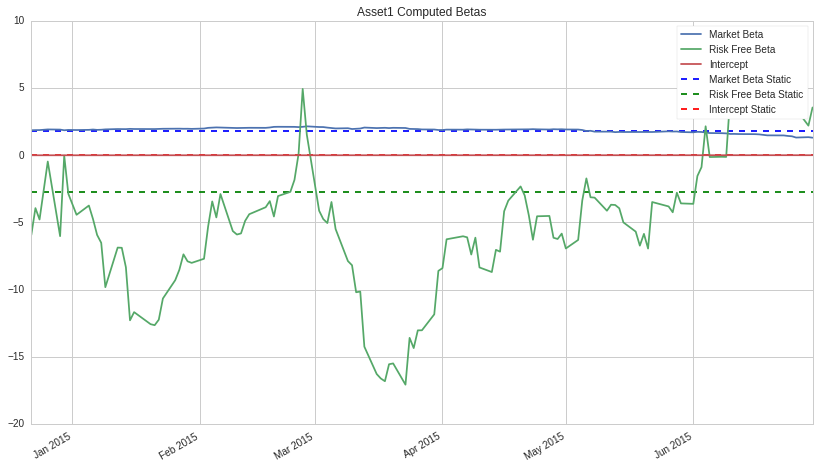

In [12]:
model = pd.stats.ols.MovingOLS(y = df['R1'], x=df[['SPY', 'RF']], 
                             window_type='rolling', 
                             window=100)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates.plot();

plt.hlines(R1_params['SPY'], df.index[0], df.index[-1], linestyles='dashed', colors='blue')
plt.hlines(R1_params['RF'], df.index[0], df.index[-1], linestyles='dashed', colors='green')
plt.hlines(R1_params['Constant'], df.index[0], df.index[-1], linestyles='dashed', colors='red')

plt.title('Asset1 Computed Betas');
plt.legend(['Market Beta', 'Risk Free Beta', 'Intercept', 'Market Beta Static', 'Risk Free Beta Static', 'Intercept Static']);

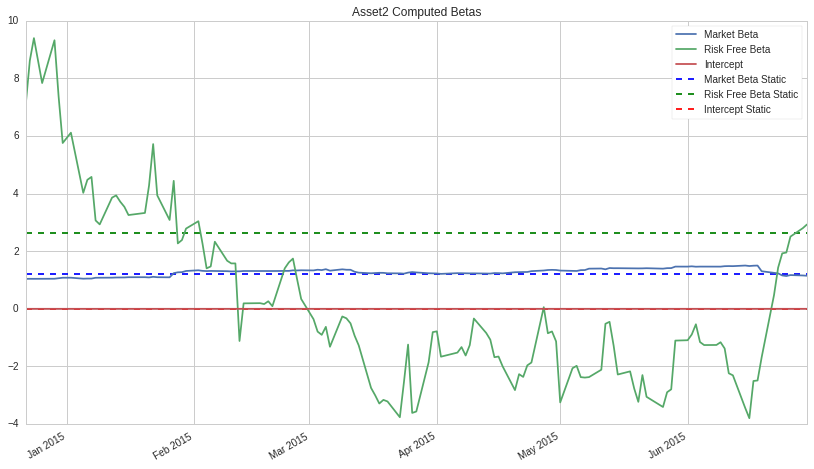

In [13]:
model = pd.stats.ols.MovingOLS(y = df['R2'], x=df[['SPY', 'RF']], 
                             window_type='rolling', 
                             window=100)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates.plot();

plt.hlines(R2_params['SPY'], df.index[0], df.index[-1], linestyles='dashed', colors='blue')
plt.hlines(R2_params['RF'], df.index[0], df.index[-1], linestyles='dashed', colors='green')
plt.hlines(R2_params['Constant'], df.index[0], df.index[-1], linestyles='dashed', colors='red')

plt.title('Asset2 Computed Betas');
plt.legend(['Market Beta', 'Risk Free Beta', 'Intercept', 'Market Beta Static', 'Risk Free Beta Static', 'Intercept Static']);

It might seem like the market betas are stable here, but let's zoom in to check.

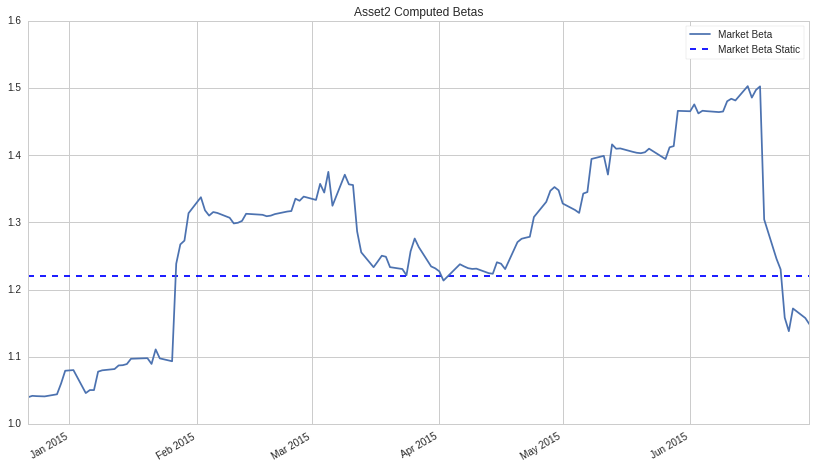

In [14]:
model = pd.stats.ols.MovingOLS(y = df['R2'], x=df[['SPY', 'RF']], 
                             window_type='rolling', 
                             window=100)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates['SPY'].plot();

plt.hlines(R2_params['SPY'], df.index[0], df.index[-1], linestyles='dashed', colors='blue')

plt.title('Asset2 Computed Betas');
plt.legend(['Market Beta', 'Market Beta Static']);

The plot scale massively affected how we perceived the estimates quality.

##Predicting the Future

Let's use this model to predict future prices for these assets.

In [16]:
start_date = '2014-07-25'
end_date = '2015-07-25'

# We will look at the returns of an asset one-month into the future to model future returns.
offset_start_date = '2014-08-25'
offset_end_date = '2015-08-25'

# Get returns data for our assets
asset1 = get_pricing('HSC', fields='price', start_date=offset_start_date, end_date=offset_end_date).pct_change()[1:]
# Get returns for the market
bench = get_pricing('SPY', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]
# Use an ETF that tracks 3-month T-bills as our risk-free rate of return
treasury_ret = get_pricing('BIL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]


# Define a constant to compute intercept
constant = pd.Series(np.ones(len(asset1.index)), index=asset1.index)

df = pd.DataFrame({'R1': asset1,
              'SPY': bench,
              'RF': treasury_ret,
              'Constant': constant})
df = df.dropna()

We'll perform a historical regression to get our model parameter estimates.

In [17]:
OLS_model = regression.linear_model.OLS(df['R1'], df[['SPY', 'RF', 'Constant']])
fitted_model = OLS_model.fit()

b_SPY = fitted_model.params['SPY']
b_RF = fitted_model.params['RF']
a = fitted_model.params['Constant']

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     R1   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     70.24
Date:                Wed, 10 Apr 2019   Prob (F-statistic):           1.80e-24
Time:                        22:45:00   Log-Likelihood:                 607.49
No. Observations:                 230   AIC:                            -1209.
Df Residuals:                     227   BIC:                            -1199.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
SPY            1.7528      0.148     11.836      0.000         1.461     2.045
RF             2.5155      8.942      0.281      0.779       -15.105    20.136
Constant      -0.0025      0.001     -2.146      0.033        -0.005    -0.000
==============================================================================
Omnibus:                        8.911   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               13.785
Skew:                          -0.211   Prob(JB):                      0.00102
Kurtosis:                       4.122   Cond. No.                     7.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Get the factor data for the last month so we can predict the next month.

In [18]:
start_date = '2015-07-25'
end_date = '2015-08-25'

# Get returns for the market
last_month_bench = get_pricing('SPY', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]
# Use an ETF that tracks 3-month T-bills as our risk-free rate of return
last_month_treasury_ret = get_pricing('BIL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

Make predictions.

In [19]:
predictions = b_SPY * last_month_bench + b_RF * last_month_treasury_ret + a
predictions.index = predictions.index + pd.DateOffset(months=1)

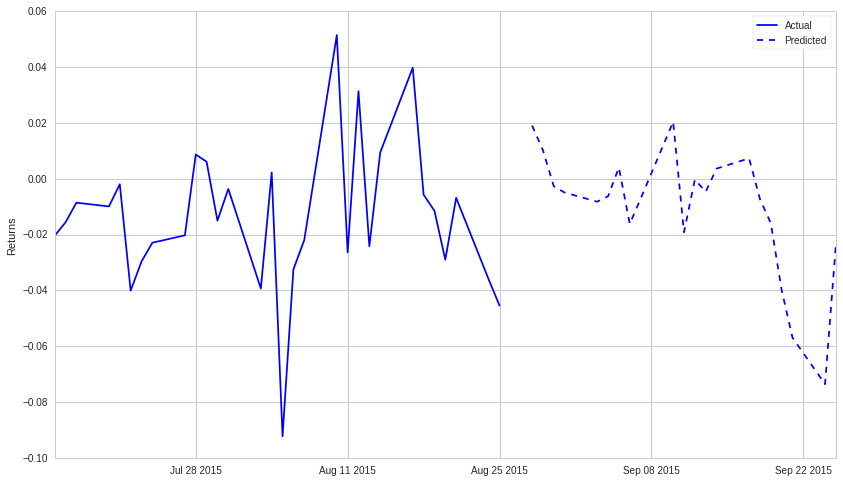

In [20]:
plt.plot(asset1.index[-30:], asset1.values[-30:], 'b-')
plt.plot(predictions.index, predictions, 'b--')
plt.ylabel('Returns')
plt.legend(['Actual', 'Predicted']);